# AGB Yields
This notebook explores different representations and uncertanties with the 
AGB yield tables we have as applied to GCE Models.
In particular, we consider the yield tables as 2D functions of mass and metallicity,
1D functions of metallicity, and 1D functions of time.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy

import vice

import arya
import surp
from surp._globals import AGB_MODELS
from surp import yields
from surp.yields import calc_y
from surp.gce_math import Z_SUN, MH_to_Z, Z_to_MH

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
AGB_MODELS

['cristallo11', 'ventura13', 'karakas16', 'battino19']

In [4]:
from singlezone import run_singlezone

In [5]:
surp.set_yields()

In [6]:
y_agb = vice.yields.agb.settings

In [7]:
agb_grid = vice.yields.agb.grid

In [8]:
agb_interpolator = surp.agb_interpolator.interpolator

In [9]:
AGB_LABELS = ["FRUITY", "ATON", "Monash",  "NuGrid"]

In [10]:
AGB_MODELS, AGB_LABELS

(['cristallo11', 'ventura13', 'karakas16', 'battino19'],
 ['FRUITY', 'ATON', 'Monash', 'NuGrid'])

In [22]:
Z_max = 0.04
Z_min = 0.0001

hmap = arya.HueMap((Z_to_MH(Z_min),Z_to_MH(Z_max)))


def plot_yield_table(study = "cristallo11", hmap=hmap, ele="c", fmt="o", 
                     ax=None, fig=None, factor=1, **kwargs):
    """
    Plots the yield table in VICE (without modification) for each metallicity
    """
    
    if ax is None:
        ax = plt.gca()
        ylabel = r"$Y_{\rm C}^{\rm AGB}$"
        if factor != 1:
            ylabel += r"$\quad [\times 10^{-%i}]$" % np.log10(factor)
        ax.set(xlabel=r'Mass / ${\rm M}_\odot$', ylabel=ylabel )
        
    yields, masses, Zs = agb_grid(ele, study=study)
    N = len(Zs)
    y_agb = surp.agb_interpolator.interpolator("c", study=study)

    for i in range(N):
        y = np.array(yields)[:,i] * factor
        Z = Zs[i]
        c = hmap(Z_to_MH(Z))
        f = ax.plot(masses, y, fmt, label=f"Z = {Z}", c=c, **kwargs)

        x = np.linspace(1, 8, 1000)
        
        y = [y_agb(m, Z) * factor for m in x]
        ax.plot(x, y, c=c, lw=0.5, **kwargs)
        
    ax.axhline(0, color="k", ls=":", zorder=-1)

    return f

In [23]:
def plot_yields(study = "cristallo11", masses=np.linspace(0.08, 8.01, 1000), Zs=None, ele="c", 
                ax=None, fig=None, hmap=hmap, factor=1, **kwargs):
    """
    Plots the yields (assuming the current setting is a surp.agb_interpolator)
    for each given mass and metallicity.
    
    """
    
    if ax is None:
        ax = plt.gca()
        ylabel = r"$Y_{\rm C}^{\rm AGB}$"
        if factor != 1:
            ylabel += r"$\quad [\times 10^{-%i}]$" % np.log10(factor)
        ax.set(xlabel=r'Mass / ${\rm M}_\odot$', ylabel=ylabel )


    if Zs is None:
        _yields, _masses, Zs = agb_grid(ele, study=y_agb[ele].study)
    
    ya = y_agb[ele]
    for i in range(len(Zs)):
        Z = Zs[i] 
        c = hmap(Z_to_MH(Z))
        y = [ya(m, Z)*factor for m in masses]
        f = ax.plot(masses, y, label=f"Z = {Z}", c=c, lw=0.15, **kwargs)

    return f

In [24]:
?surp.yields.calc_y

Signature: surp.yields.calc_y(Z=0.0176, ele='c', kind='all', t_end=10)
Docstring: <no docstring>
File:      /arc7/home/dboyea/surp/surp/yields.py
Type:      function

In [25]:
def plot_y_z(Zs=MH_to_Z(np.linspace(-2.7, 0.6, 100)), ele="c", kind="agb", fmt="-", factor = 1e4, **kwargs):
    """
        plot_y_z(Zs, ele, kind, fmt, factor, kwargs)
    
    plots the metallicity dependence of the AGB yield over a given range of metallicities. 
    Uses the current yield setting
    """
    
    y_c_agb = calc_y(Zs, ele=ele, kind=kind) * factor
    
    plt.axhline(0, color="k", ls=":")
    plt.xlabel(r"$\log Z/Z_\odot$")
    plt.ylabel(r"$y_{\rm C}^{\rm AGB}\quad[\times 10^{-%i}]$" % np.log10(factor))
    
    return plt.plot(Z_to_MH(Zs), y_c_agb, fmt, **kwargs), y_c_agb

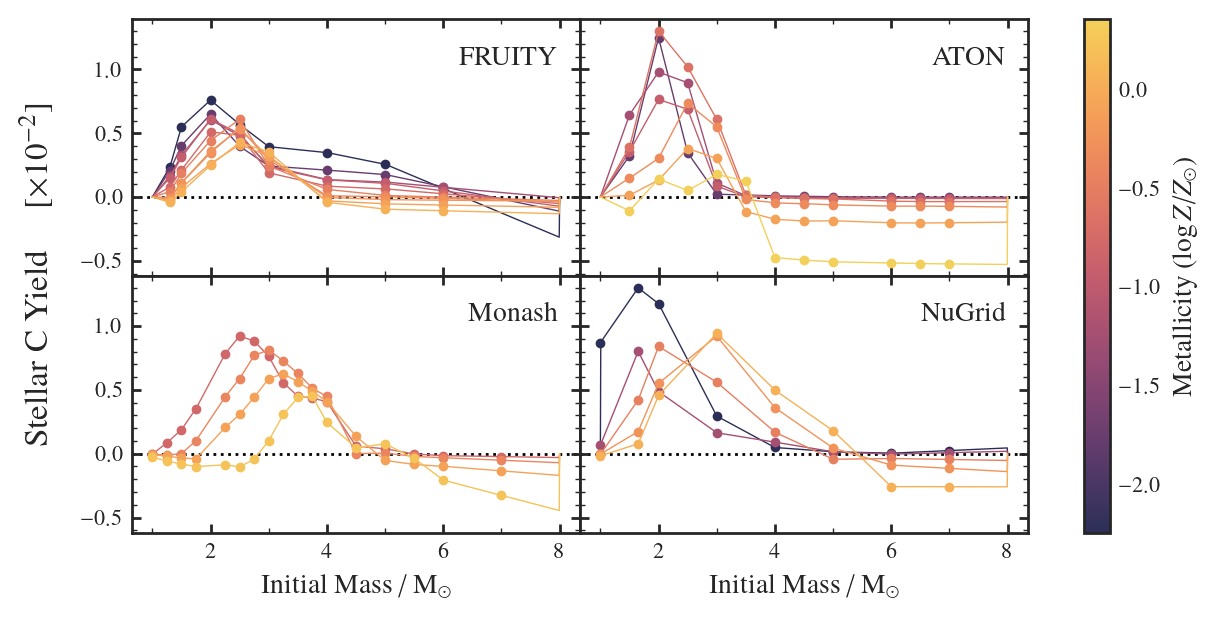

In [26]:
SCALE_FACTOR=1e2
fig, axs = plt.subplots(2, 2, figsize=(7, 10/3), sharex=True, sharey=True, gridspec_kw={"hspace":0, "wspace": 0, "left": 0.1})

for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    ax = axs[i//2][i%2]
    f = plot_yield_table(study, ax=ax, 
                         fig=fig, fmt="o", factor=SCALE_FACTOR)
    
    # plot label
    ax.text(0.95, 0.9, label, horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes)
    


arya.Colorbar(huemap=hmap, ax=axs.ravel().tolist(), 
              label=r"Metallicity ($\log Z/Z_\odot$)")

plt.setp(axs[-1, :], xlabel=r'Initial Mass / ${\rm M}_\odot$')
fig.supylabel(r"Stellar C Yield $\quad[\times 10^{-2}]$")

plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

plt.savefig("figures/agb_yields.pdf")

The AGB figure of the paper

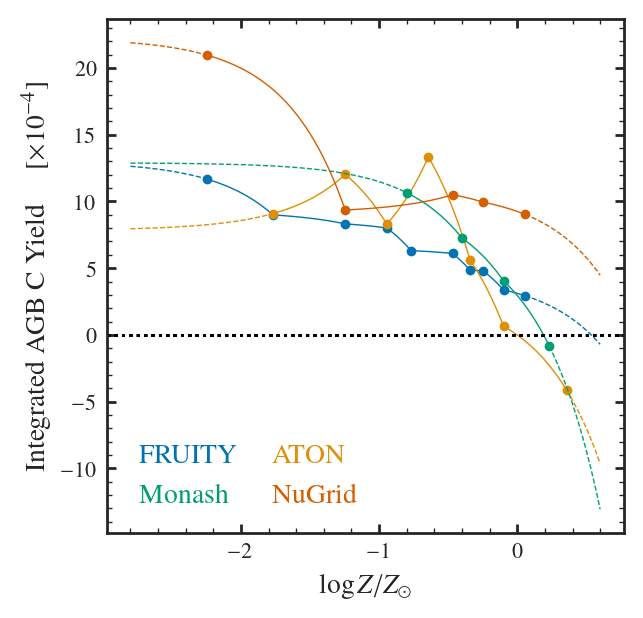

In [27]:
x_min = -2.8
x_max = 0.6
N_points = 100
scale = 1e4
ele = "c"

vice.yields.ccsne.settings[ele] = 0
vice.yields.sneia.settings[ele] = 0

plt.figure(figsize=(10/3, 10/3))

for i in range(4):
    model = AGB_MODELS[i]

    vice.yields.agb.settings[ele] = agb_interpolator(ele, study=model)
    kwargs = dict(fmt="o", zorder=i, factor=scale, color=arya.COLORS[i])
    
    # plots importaint points
    _y1, _m1, Zs = vice.yields.agb.grid('c', study=model)
    (line,), _x = plot_y_z(Zs, **kwargs)
    
    # plot solid within range
    MoverH_min = Z_to_MH(min(Zs))
    MoverH_max = Z_to_MH(max(Zs))
    
    kwargs["fmt"] = "-"
    kwargs["lw"] = 0.5
    Zs = MH_to_Z(np.linspace(MoverH_min, MoverH_max, N_points))
    plot_y_z(Zs, label=AGB_LABELS[i], **kwargs)

    # dashed extrapolation
    kwargs["fmt"] = "--"
    Zs = MH_to_Z(np.linspace(x_min, MoverH_min, N_points))    
    plot_y_z(Zs, **kwargs)
    Zs = MH_to_Z(np.linspace(MoverH_max, x_max, N_points))
    plot_y_z(Zs, **kwargs)





arya.Legend(color_only=True, handlelength=0, ncols=2, columnspacing=1, loc=3, transpose=True)
plt.ylabel(r"Integrated AGB C Yield $\quad [\times 10^{-4}]$")
plt.savefig("figures/y_agb_vs_z.pdf")

In [28]:
tau_switch = 1
def plot_ssp_time(ele="c", Z=surp.Z_SUN, imf="kroupa", normalize=True, dt=0.01, t_end=10, color=None, verbose=True, **kwargs):
    """
        plot_ssp_time(ele, Z, normalize, **kwargs(
        
    plots the SSP yield over time for the current yield setting
    """
    
    m_c, times = vice.single_stellar_population(ele, Z=Z, dt=dt, time=t_end, mstar=1, IMF=imf)
    
    y = np.array(m_c)
    if normalize:
        y /= y[-1]
    
    plt.plot(times, y, color=color, **kwargs)
    
    
    # plot 50% time
    f = scipy.interpolate.interp1d(y, times)

    y_1_2 = 0.5*y[-1]
    plt.scatter(f(y_1_2), y_1_2, color=color)
        
    if verbose:
        print(f"model = {y_agb[ele]}")
        print(f"t1/2 = {f(y_1_2):0.2f}")

        times = np.array(times)
        idx = np.where(times >= tau_switch)[0][1]

        y_late = y[-1] - y[idx]
        print(f"y(t>{times[idx]}) = {y_late:0.2f}")
        print(f"y max = {np.max(y):0.2f}")
        print(f"y min = {np.min(y):0.2f}")
        print(f"t min = {times[np.argmin(y)]:0.2f}")
   
        print()
    
    plt.xlabel(r"$t$ / Gyr")
    plt.xscale("log")
    
    if normalize:
        plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
    else:
        plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)$")

    
    return times, y

model = 1.00 × cristallo11
t1/2 = 0.79
y(t>1.01) = 0.34
y max = 1.04
y min = -0.23
t min = 0.21

model = 1.00 × ventura13
t1/2 = 4.77
y(t>1.01) = -59.55
y max = 279.13
y min = -0.37
t min = 2.86

model = 1.00 × karakas16
t1/2 = 0.36
y(t>1.01) = -0.10
y max = 1.13
y min = -0.27
t min = 0.12

model = 1.00 × battino19
t1/2 = 0.53
y(t>1.01) = 0.22
y max = 1.00
y min = -0.10
t min = 0.10

model = 0
t1/2 = 0.96
y(t>1.01) = 0.49
y max = 1.00
y min = 0.00
t min = 0.00



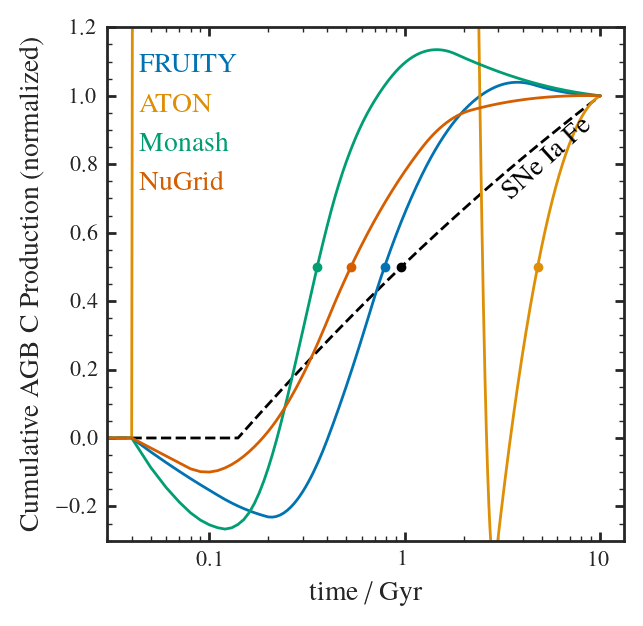

In [29]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
vice.yields.agb.settings["fe"] = surp.yield_models.ZeroAGB()


for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=model)
    times, y = plot_ssp_time(label=AGB_LABELS[i])
  
    
plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")
plot_ssp_time("fe", color="k", ls="--", zorder=-1)


plt.ylim(-0.3, 1.2)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])
plt.ylabel("Cumulative AGB C Production (normalized)")
plt.xlabel("time / Gyr")
arya.Legend(color_only=True)

plt.savefig("figures/y_agb_vs_t.pdf")

# Extra

In [ ]:
fig, axs = plt.subplots(2, 1, 
    figsize=(10/3, 10/3), 
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0, "wspace": 0, "left": 0.1})

plt.sca(axs[0])
ax = axs[0]
plot_yield_table("pignatari16", fmt="o-", factor=1)
ax.text(0.95, 0.9, "pignatari16", horizontalalignment='right',
        verticalalignment='top', transform=ax.transAxes)


plt.sca(axs[1])
plot_yield_table("battino19", fmt="o-", factor=1)
ax = axs[1]
ax.text(0.95, 0.9, "battino19", horizontalalignment='right',
        verticalalignment='top', transform=ax.transAxes)

arya.Colorbar(huemap=hmap, ax=axs.ravel().tolist(), 
              label=r"Metallicity ($\log Z/Z_\odot$)")


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10/3, 10/3), sharex=True, sharey=True, gridspec_kw={"hspace":0, "wspace": 0, "left": 0.1})

plt.sca(axs[0])
ax = axs[0]
plot_yield_table("pignatari16", fmt="o-", ele="ba", factor=1,)
ax.text(0.95, 0.9, "pignatari16", horizontalalignment='right',
        verticalalignment='top', transform=ax.transAxes)

plt.ylabel(r"$Y_{\rm Ba}$")
plt.sca(axs[1])
plot_yield_table("battino19", fmt="o-", factor=1, ele="ba",)
ax = axs[1]
ax.text(0.95, 0.9, "battino19",  horizontalalignment='right',
        verticalalignment='top', transform=ax.transAxes)

arya.Colorbar(huemap=hmap, ax=axs.ravel().tolist(), label=r"Metallicity ($\log Z/Z_\odot$)")
plt.yscale("log")
plt.ylabel(r"$Y_{\rm Ba}$")

## DTS

In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    plot_ssp_time(label=model)
    

plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")
plot_ssp_time("fe", color="k", ls="--")

plt.ylim(-0.3, 1.2)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])


In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
vice.yields.agb.settings["fe"] = surp.yield_models.ZeroAGB()
Z = MH_to_Z(-0.0)


for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=model)
    plot_ssp_time(normalize=False, Z=Z, label=model, verbose=False)



plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])
arya.Legend(-1)


same as figure just above but for VICE default settings

In [ ]:
cmap = arya.style.get_cmap()



model = "cristallo11"
mpp = arya.figure.colorbar.HueMap([-4, 1])


for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)
    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    y_agb["c"] = agb_interpolator("c", study=model)
    for i in range(len(z1)):
        z = z1[i]
        plot_ssp_time(Z=z, color=hmap(Z_to_MH(z)), normalize=False, verbose=False)



    arya.Colorbar(huemap=mpp, ax=plt.gca())
    plt.show()

In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
    y = np.array(m_c)/m_c[-1]
    dt = times[1] - times[0]
    plt.plot(times[:-1], (y[1:] - y[:-1])/dt)
        

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
y = np.array(m_fe)/m_fe[-1]
plt.plot(times[:-1], (y[1:] - y[:-1])/dt, 
         linestyle="--", zorder=-1, color="k")



plt.xlabel(r"$t$ (Gyr)")
plt.ylabel(r"$y(t)\;/\;y(t_{\rm end})$")
plt.xscale("log")
plt.xlim(0.03, 13.2)
plt.ylim(0, 4)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])
x = np.array(times)


vice.yields.agb.settings["c"] = surp.yield_models.C_AGB_Model()
m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
y = np.array(m_c)/m_c[-1]
dt = times[1] - times[0]
plt.plot(times[:-1], (y[1:] - y[:-1])/dt)

arya.Legend(-1)

## yields 

In [ ]:
Zs = MH_to_Z(np.arange(-2.5, 0.8, 0.2))
for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    y_agb["c"] = agb_interpolator("c", study=study)
    plot_yields(study, Zs=Zs)
    plt.xlabel(r'Mass / ${\rm M}_\odot$')
    plt.ylabel(r"AGB C yield ($\times 10^{-2}$)")
    plt.title(label)
    plt.show()

## Interpolation methods

In [ ]:
y_c_lin = agb_interpolator("c", interp_kind="linear", low_z_flat=False)
y_c_log = agb_interpolator("c", interp_kind="log", low_z_flat=True)
y_c_spline = agb_interpolator("c", interp_kind="spline")

y_cs = {
    "linear": y_c_lin,
    "log": y_c_log,
    "spline": y_c_spline
}

In [ ]:
# just making sure this works
surp.set_yields(surp.YieldParams.from_file("../models/fruity/agb_spline_interp/yield_params.toml"))
plot_yields()

In [ ]:
Z = MH_to_Z(np.linspace(-3, 1, 15))

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model

    plot_yields()
    plot_yield_table()
    plt.title(label)
    plt.show()



In [ ]:
Zs = MH_to_Z(np.linspace(-3, 1, 15))

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model

    plot_yields(Zs=Zs)
    plt.title(label)
    plt.show()



In [ ]:
Z = 0.016
vice.yields.ccsne.settings["c"] = 0
for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model

    plot_ssp_time(normalize=False, Z=Z, label=label)

arya.Legend(-1)


In [ ]:

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model
    plot_y_z(label=label)

arya.Legend(-1)


Like DTD figures but for the derivative.

In [ ]:
params_lin = surp.YieldParams.from_file("../models/C11_f0.2_lininterp/yield_params.toml")
params_fiducial = surp.YieldParams.from_file("../models/C11_f0.2/yield_params.toml")

params_lin.c_agb_alpha = 1
params_fiducial.c_agb_alpha = 1

In [ ]:

surp.yields.set_yields(params_fiducial, verbose=False)
plot_y_z(Zs);

surp.yields.set_yields(params_lin, verbose=False)
plot_y_z(Zs);


vice.yields.agb.settings["c"] = "cristallo11"
plot_y_z(Zs, ls="--");

plt.xlabel("[M/H]")
plt.ylabel("yield")

In [ ]:
plt.figure(figsize=(10/3, 10/3))

Z = MH_to_Z(0.5)


for params in [params_fiducial, params_lin]:
    surp.yields.set_yields(params, verbose=False)
    vice.yields.ccsne.settings["c"] = 0
    vice.yields.sneia.settings["c"] = 0
    vice.yields.ccsne.settings["fe"] = 0
    vice.yields.agb.settings["fe"] = surp.yield_models.ZeroAGB()
    
    times, y = plot_ssp_time(normalize=False, Z=Z)

    print()

vice.yields.agb.settings["c"] = "cristallo11"
times, y = plot_ssp_time(normalize=False, Z=Z, ls="--")

arya.Legend(-1)

plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
plt.xscale("log")

## Lowest mass & negative yields

In [ ]:

study = "cristallo11"

y_cs = {
    "y_c_extrap": agb_interpolator("c", study=study, min_mass=0.08, pinch_mass=None),
    "y_c_no_neg":  agb_interpolator("c", study=study,min_mass=0.08, no_negative=True, no_negative_mass=1.5, pinch_mass=None),
    "y_c_pinch":  agb_interpolator("c", study=study,pinch_mass=0.5),
    "y_c_pinch_1":  agb_interpolator("c", study=study),

    "y_c_trunc":  agb_interpolator("c", study=study, min_mass="lowest", pinch_mass=None),
}

In [ ]:
Zs = MH_to_Z(np.linspace(-3, 1, 15))

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model

    plot_yields(Zs=Zs)
    plt.title(label)
    plt.xlim(0.08, 4)
    plt.show()



In [ ]:
for Z in [1e-4, 0.001, 0.016, 0.03]:
    vice.yields.ccsne.settings["c"] = 0
    for label, model in y_cs.items():
        vice.yields.agb.settings["c"] = model

        plot_ssp_time(normalize=False, Z=Z, label=label)

    arya.Legend(-1)
    plt.title(Z)
    plt.xlim(0.3)

    plt.show()


In [ ]:

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model
    plot_y_z(label=label)

arya.Legend(-1)


## Nitrogen

## Testing the oob settings

In [ ]:
plt.figure(figsize=(10/3, 10/3))



for i in range(4):
    model = AGB_LABELS[i]
    yname = f"../models/{model}_oob/yield_params.json"
    surp.set_yields(surp.YieldParams.from_file(yname))
    vice.yields.ccsne.settings["c"] = 0
    times, y = plot_ssp_time()
    
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=AGB_MODELS[i])
    times, y = plot_ssp_time()



plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
plt.xscale("log")

plt.ylim(-0.3, 1.2)
plt.xlim(0.03, 13.2)

As expected, the surp yield settings exactly reproduce what the interpolator uses

In [ ]:
x_min = -2.5
x_max = 0.6
N_points = 100
scale = 1e4
ele = "c"

vice.yields.ccsne.settings[ele] = 0
vice.yields.sneia.settings[ele] = 0

plt.figure(figsize=(10/3, 10/3))

MoverH_min = -2.5
MoverH_max = 0.5
Zs = MH_to_Z(np.linspace(MoverH_min, MoverH_max, N_points))


for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings[ele] = agb_interpolator(ele, study=model)
    plot_y_z(Zs, label=AGB_LABELS[i], fmt="-")
    
    model = AGB_LABELS[i]
    yname = f"../models/{model}_oob/yield_params.json"
    surp.set_yields(surp.YieldParams.from_file(yname))
    vice.yields.ccsne.settings["c"] = 0
    
    plot_y_z(Zs, label=AGB_LABELS[i], fmt="-")

plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}\quad[\times 10^{-4}]$")


arya.Legend(color_only=True, handlelength=0, ncols=2, columnspacing=1, loc=3, transpose=True)

## M factors

In [ ]:
m_factors = [0.25, 0.5, 0.8, 1, 1.2, 1.5]

for i in range(len(m_factors)):
    label = m_factors[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", mass_factor=m_factors[i], pinch_mass=1)
    
    plot_yields()
    plt.title(f"m factor = {label}")
    plt.show()

In [ ]:
Z = MH_to_Z(-0.1)


m_factors = [0.5, 0.8, 1, 1.2, 1.5]

for i in range(len(m_factors)):
    label = m_factors[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", mass_factor=m_factors[i])
    plot_ssp_time(normalize=False, Z=Z, label=m_factors[i])


vice.yields.ccsne.settings["fe"] = 0
plot_ssp_time("fe", color="k", normalize=False, ls="--", Z=Z)

arya.Legend(-1, title="mass factor")


plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])


In [ ]:
Z = MH_to_Z(-0.1)


m_factors = [0.5, 0.8, 1, 1.2, 1.5]

for i in range(len(m_factors)):
    label = m_factors[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", mass_factor=m_factors[i])
    plot_y_z(label=m_factors[i])



arya.Legend(-1, title="mass factor")



# IMF and MLR

In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
vice.yields.agb.settings["fe"] = surp.yield_models.ZeroAGB()
Z = MH_to_Z(-0.1)

vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11")
mlrs = ["powerlaw", "vincenzo2016", "hpt2000", "ka1997", "pm1993", "mm1989", "larson1974"]

for i in range(len(mlrs)):
    label = mlrs[i]
    print(label)
    vice.mlr.setting = mlrs[i]
    
    times, y = plot_ssp_time(normalize=False, Z=Z, label=label)

    print()


arya.Legend(-1)

plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
plt.xscale("log")



the MLR relation only results in small changes in the DTD.

In [ ]:
plt.figure(figsize=(10/3, 10/3))

Z = MH_to_Z(-0.1)
vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11")

times, y = plot_ssp_time(normalize=True, Z=Z, label="kroupa")
times, y = plot_ssp_time(normalize=True, Z=Z, label="salpeter", imf="salpeter")


arya.Legend(-1)

